# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

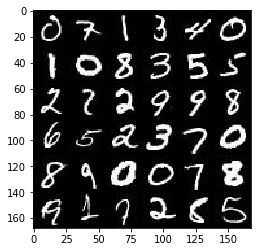

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

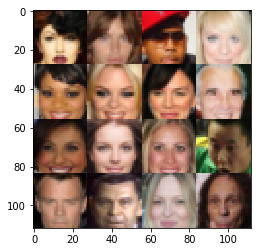

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None, image_width, image_height,image_channels], name='x')
    
    input_z = tf.placeholder(tf.float32, [None,z_dim], name='z')
    
    lr = tf.placeholder(tf.float32,name='lr')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        flat = tf.reshape(relu2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    if is_train==False:
        reuse=True 
    if is_train==True:
        reuse=False 
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))

        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, lr, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 7.2504
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 8.8594
Epoch 1/2... Discriminator Loss: 0.4812... Generator Loss: 3.2776
Epoch 1/2... Discriminator Loss: 0.3858... Generator Loss: 4.7548
Epoch 1/2... Discriminator Loss: 0.3611... Generator Loss: 5.6383
Epoch 1/2... Discriminator Loss: 1.9503... Generator Loss: 22.8013
Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 8.5565
Epoch 1/2... Discriminator Loss: 2.3194... Generator Loss: 0.2500
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.7039
Epoch 1/2... Discriminator Loss: 1.9466... Generator Loss: 1.7756


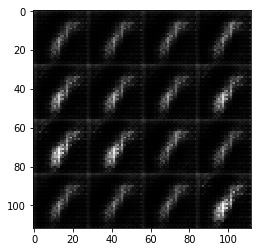

Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 9.0091
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 4.3874
Epoch 1/2... Discriminator Loss: 0.6259... Generator Loss: 8.2799
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 8.6791
Epoch 1/2... Discriminator Loss: 3.3604... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 0.5592... Generator Loss: 4.8895
Epoch 1/2... Discriminator Loss: 0.6855... Generator Loss: 4.4899
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 3.4491
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 3.4740
Epoch 1/2... Discriminator Loss: 2.5839... Generator Loss: 13.3439


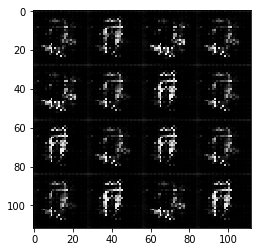

Epoch 1/2... Discriminator Loss: 0.5120... Generator Loss: 3.6996
Epoch 1/2... Discriminator Loss: 0.5414... Generator Loss: 3.4702
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 2.0829
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 2.5152
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.8926
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 3.9246
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 5.9528
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 8.4516
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 2.4784


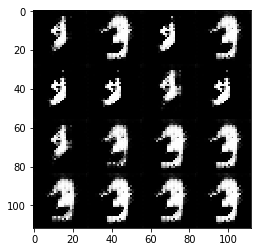

Epoch 1/2... Discriminator Loss: 4.6010... Generator Loss: 16.4387
Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 3.9357
Epoch 1/2... Discriminator Loss: 0.4864... Generator Loss: 6.3368
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 3.0562
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 4.7393
Epoch 1/2... Discriminator Loss: 0.4946... Generator Loss: 4.3897
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 3.1020
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 2.4033
Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 3.7498
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 3.5615


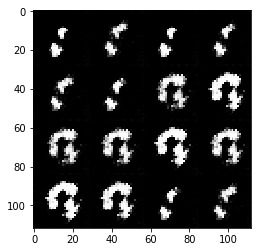

Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 4.1948
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 4.7552
Epoch 1/2... Discriminator Loss: 0.5045... Generator Loss: 4.3259
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 1.7327
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 6.0401
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 2.4446
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 2.6487
Epoch 1/2... Discriminator Loss: 0.5454... Generator Loss: 3.0127
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 6.8579
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 2.2960


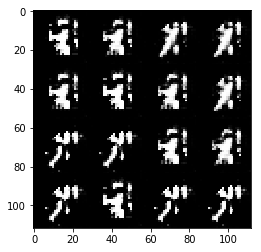

Epoch 1/2... Discriminator Loss: 2.7107... Generator Loss: 1.0945
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 3.9265
Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 12.2828
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 4.1737
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 8.2319
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 2.8899
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 3.4085
Epoch 1/2... Discriminator Loss: 0.5855... Generator Loss: 3.5835
Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 5.0297
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 9.8102


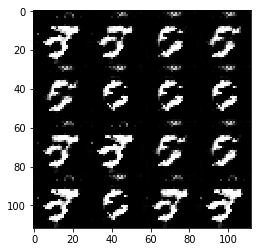

Epoch 1/2... Discriminator Loss: 1.5396... Generator Loss: 8.4515
Epoch 1/2... Discriminator Loss: 1.7492... Generator Loss: 15.1219
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 5.0933
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 5.1990
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 2.1938
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 4.4382
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.9540
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 3.1493
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 2.2263... Generator Loss: 1.0652


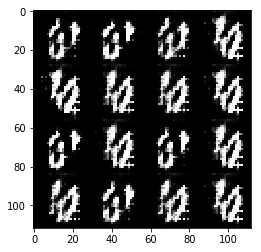

Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 5.1779
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 3.9047
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 5.8249
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 2.8575
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 2.8381
Epoch 1/2... Discriminator Loss: 5.4956... Generator Loss: 0.0999
Epoch 1/2... Discriminator Loss: 0.4992... Generator Loss: 6.0465
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 12.0397
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 2.3732


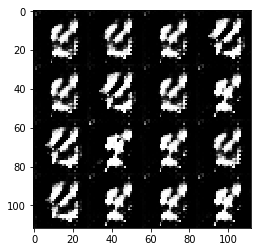

Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 7.3710
Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 5.4320
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 2.1151
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 2.1607
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 0.4950... Generator Loss: 3.8378
Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 1.8165
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 4.4002
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 3.0776


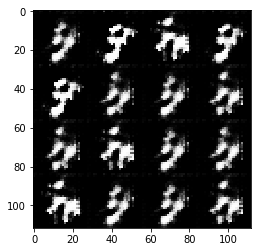

Epoch 1/2... Discriminator Loss: 2.2294... Generator Loss: 0.3910
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 1.4365
Epoch 1/2... Discriminator Loss: 2.0262... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 3.8946
Epoch 2/2... Discriminator Loss: 2.0664... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 2.4250
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.2871
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 11.3869
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.9560


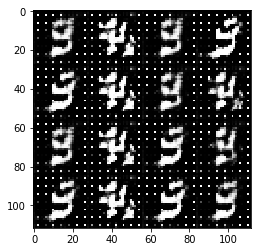

Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 4.3150
Epoch 2/2... Discriminator Loss: 1.9545... Generator Loss: 0.4613
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 2.0695
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 5.3424
Epoch 2/2... Discriminator Loss: 0.6693... Generator Loss: 3.9337
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.9453
Epoch 2/2... Discriminator Loss: 1.5011... Generator Loss: 7.0234
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 6.5829
Epoch 2/2... Discriminator Loss: 2.8989... Generator Loss: 11.0123


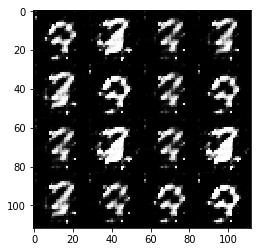

Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 4.4661
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 2.3288
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 10.8425
Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 5.3413
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 7.7730
Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 2.0858
Epoch 2/2... Discriminator Loss: 0.6358... Generator Loss: 4.0340
Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 6.2037
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 3.4706
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 2.0012


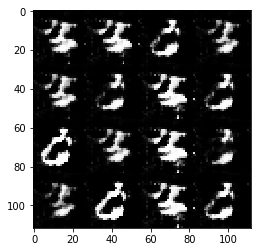

Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 3.5365
Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.8770
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 2.6924
Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 2.7408
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 2.8431
Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 3.7117
Epoch 2/2... Discriminator Loss: 2.7106... Generator Loss: 9.8267
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.5837... Generator Loss: 0.7215


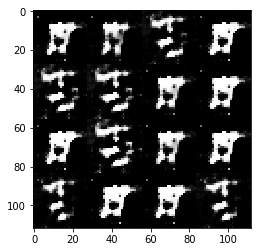

Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 7.4977
Epoch 2/2... Discriminator Loss: 1.0738... Generator Loss: 6.0772
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 5.5556
Epoch 2/2... Discriminator Loss: 0.5355... Generator Loss: 4.9939
Epoch 2/2... Discriminator Loss: 0.5367... Generator Loss: 3.2333
Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 4.4465
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 4.2183
Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 6.4158
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 2.0614
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 6.6948


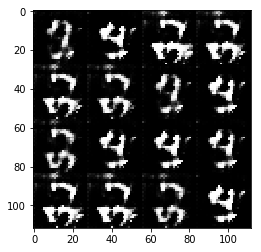

Epoch 2/2... Discriminator Loss: 1.7132... Generator Loss: 6.9792
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 3.4897
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 2.2286
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.9729
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 4.4819
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 3.7439
Epoch 2/2... Discriminator Loss: 0.6684... Generator Loss: 4.5775
Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 2.9459
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 4.0871
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 3.4839


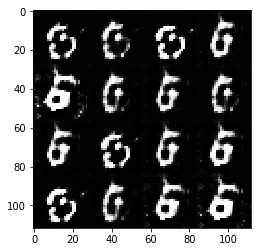

Epoch 2/2... Discriminator Loss: 0.5194... Generator Loss: 3.6540
Epoch 2/2... Discriminator Loss: 0.4859... Generator Loss: 3.2065
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 4.1439
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 7.4056
Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 2.5676
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 3.1700
Epoch 2/2... Discriminator Loss: 0.5373... Generator Loss: 2.8879
Epoch 2/2... Discriminator Loss: 4.5680... Generator Loss: 16.7219
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 2.1973
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 2.9058


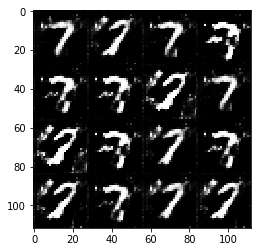

Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 5.3746
Epoch 2/2... Discriminator Loss: 1.5500... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 2.0600
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 2.2772
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 3.0007
Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 3.3153
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.5353
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 5.5098
Epoch 2/2... Discriminator Loss: 0.4992... Generator Loss: 2.8480


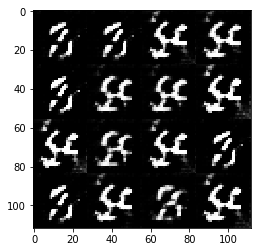

Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 2.6748
Epoch 2/2... Discriminator Loss: 0.4179... Generator Loss: 4.4496
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 2.9123
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 3.4114
Epoch 2/2... Discriminator Loss: 0.4522... Generator Loss: 3.2542
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 3.6256
Epoch 2/2... Discriminator Loss: 0.4738... Generator Loss: 2.6851
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 3.0360
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 3.7515
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 3.7613


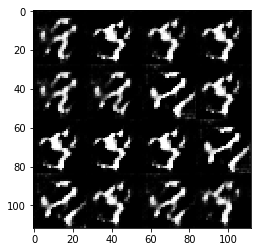

Epoch 2/2... Discriminator Loss: 0.4619... Generator Loss: 3.1806
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 4.7638
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 6.0668
Epoch 2/2... Discriminator Loss: 0.5449... Generator Loss: 3.0289
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 3.5639
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 2.7771
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 1.9034


In [12]:
batch_size = 64
z_dim = 1
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 8.5298... Generator Loss: 0.0007
Epoch 1/1... Discriminator Loss: 4.7287... Generator Loss: 0.0238
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 2.3391... Generator Loss: 8.2608
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 5.4557
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 3.1361
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 1.9897
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 1.4807
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 7.4926
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 2.1691


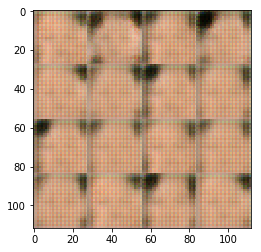

Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.8366
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 3.5481
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.0280


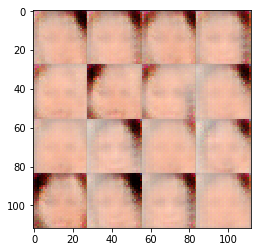

Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.7423
Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 3.8050
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.8206... Generator Loss: 3.5270
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.7632
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.7509... Generator Loss: 4.7127
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.3042


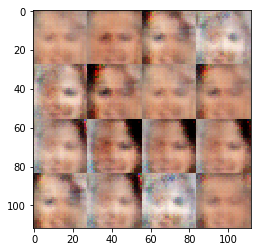

Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 2.8061
Epoch 1/1... Discriminator Loss: 1.7182... Generator Loss: 4.4002
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.8457
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 4.4681
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.1179
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.5460


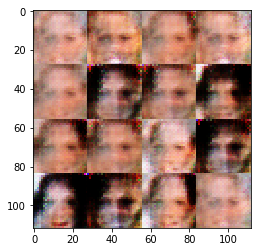

Epoch 1/1... Discriminator Loss: 2.4910... Generator Loss: 0.1872
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.3808
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 2.0570
Epoch 1/1... Discriminator Loss: 1.8992... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 2.2997
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.5928


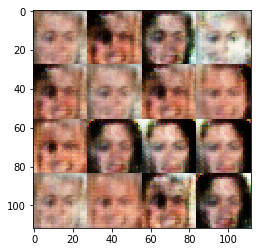

Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 2.7636
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 2.1421... Generator Loss: 4.9267
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 2.1971
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 3.8927
Epoch 1/1... Discriminator Loss: 2.2254... Generator Loss: 0.2469
Epoch 1/1... Discriminator Loss: 3.1786... Generator Loss: 5.8130
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.1284


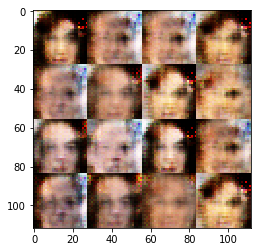

Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 2.2279
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.3223
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.8960... Generator Loss: 6.7102
Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 8.2673
Epoch 1/1... Discriminator Loss: 2.2359... Generator Loss: 6.5033
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.2136
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 3.8964
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 2.5269


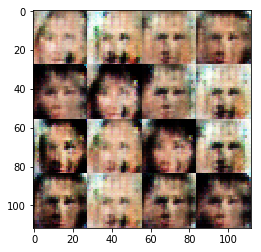

Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 2.6182
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 2.1260... Generator Loss: 3.8681
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 3.6659
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 3.3853
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 3.1460
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 3.1819
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.7540
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.2739


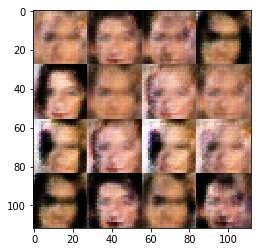

Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 3.2035... Generator Loss: 9.0447
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 5.3838
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.1030
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 2.3480
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 3.8745
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.9595
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 2.2899


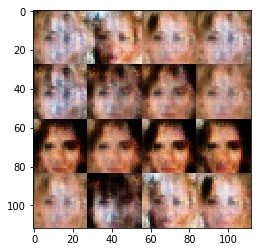

Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 2.0412
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 3.1290
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.4917
Epoch 1/1... Discriminator Loss: 1.9029... Generator Loss: 2.3127
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.6297
Epoch 1/1... Discriminator Loss: 3.0737... Generator Loss: 10.4322
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 2.5909... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 2.7764... Generator Loss: 3.3682


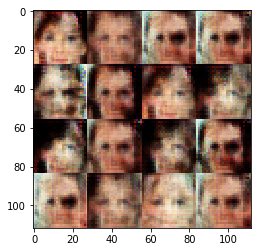

Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 2.7399
Epoch 1/1... Discriminator Loss: 2.1987... Generator Loss: 0.3079
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 2.8176
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 3.5411
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 4.2080
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 0.4576


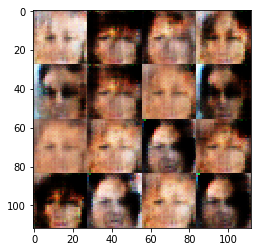

Epoch 1/1... Discriminator Loss: 1.6513... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 2.2801
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 2.6845
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 4.5868
Epoch 1/1... Discriminator Loss: 2.2002... Generator Loss: 0.2722
Epoch 1/1... Discriminator Loss: 2.1058... Generator Loss: 6.4735
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 3.9383
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 2.5368


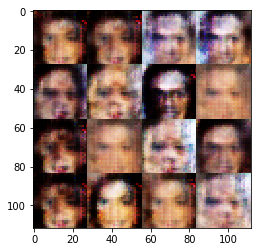

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.7302
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.6050
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 3.7530
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.4112


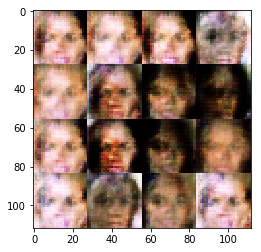

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 6.0569
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.8577
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 3.7840
Epoch 1/1... Discriminator Loss: 2.3065... Generator Loss: 4.8536
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 2.4661
Epoch 1/1... Discriminator Loss: 1.9847... Generator Loss: 6.5418


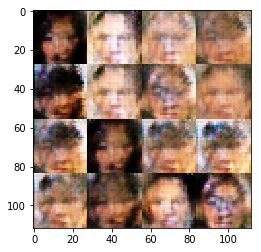

Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 4.2123
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 4.6741
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 3.0922
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 5.3200
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 3.0852
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 3.7530
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 2.0115... Generator Loss: 8.0046


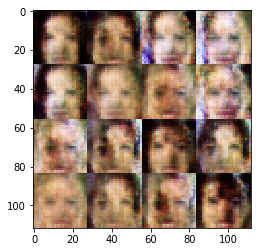

Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 4.6348
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 3.0212
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.7942
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 2.9159
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.4971


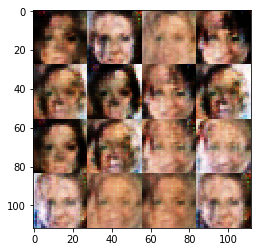

Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 2.9514
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 2.1125
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 3.1134
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.9469
Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 4.0071
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 3.4978
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.7765
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.2849
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.5800


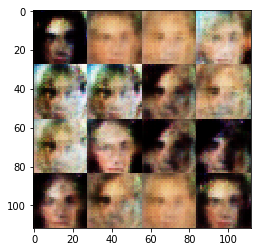

Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 2.6083
Epoch 1/1... Discriminator Loss: 2.7543... Generator Loss: 9.8655
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 4.3457
Epoch 1/1... Discriminator Loss: 1.9745... Generator Loss: 7.1672
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 5.0934
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 7.3488
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 2.4106


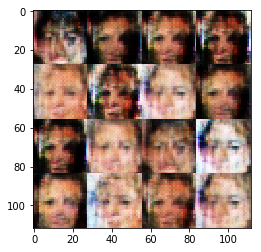

Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 2.2494
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.9191
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 3.2548
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.9801
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 2.2153
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 3.1448
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 4.8559
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 7.0109


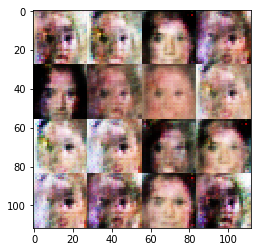

Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 3.3052
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 1.8642
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 2.8364
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 2.7538
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 2.8942
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 3.6712
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.7934
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 2.2011
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 4.0969
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 3.1467


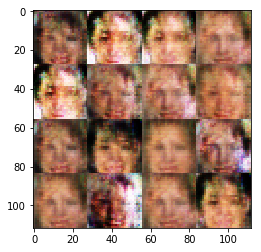

Epoch 1/1... Discriminator Loss: 1.9955... Generator Loss: 4.4224
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 5.0688
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 3.8928
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 2.8676
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 5.7305
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 2.8946


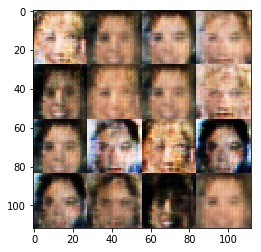

Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 2.0448
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 2.0698
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.2484
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 4.2759
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 3.5708
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 4.1443
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 3.4611
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.7386
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 3.0218


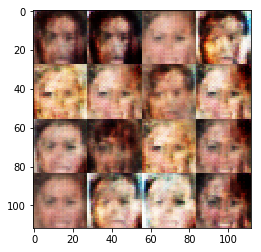

Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 3.1213
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.8777
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 6.6925
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 5.4835
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 4.9871
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 6.4663
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 3.0561
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.8097


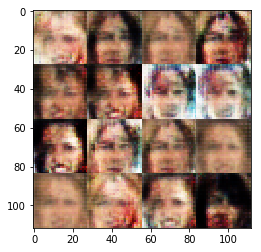

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 7.4072
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 3.5750
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 4.7948
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 3.5242
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 4.3975
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 8.3325
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 2.0701
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 3.0305


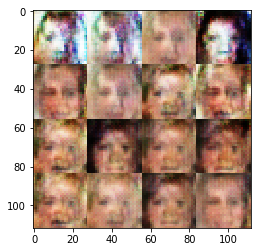

Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 2.9711
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 2.0243
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 3.4524
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 2.6060
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.7270
Epoch 1/1... Discriminator Loss: 2.2659... Generator Loss: 9.1799
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 5.2839
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 4.1367
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 3.6723
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 3.8178


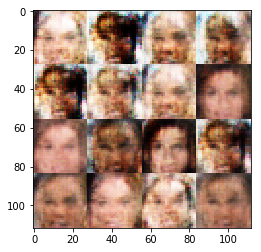

Epoch 1/1... Discriminator Loss: 2.0405... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.1707
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 2.4052
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 3.2389
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 2.5548
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.9316
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 2.7740


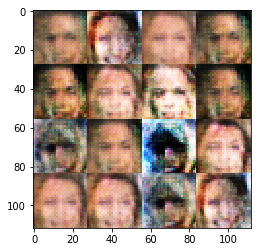

Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.9512
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 3.7473
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.7744
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 2.5611
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 2.5726
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 4.7499
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 4.4043
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.8745
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 3.6284


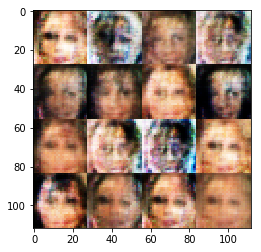

Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 3.3166
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 5.1866
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 4.2078
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 4.4570
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.8308
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 3.9915
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 2.8335
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 5.9418


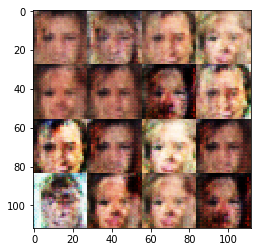

Epoch 1/1... Discriminator Loss: 1.7073... Generator Loss: 9.4280
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 7.0626
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 3.4385
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 3.7010
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 3.6566
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 2.7346
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 2.2308
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.1975


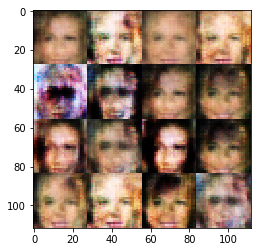

Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 2.8524
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.8605
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 2.3140
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 5.5482
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 4.0840
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.6269
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 3.2637
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 2.9185
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 4.9716


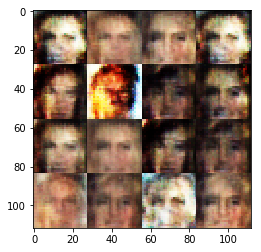

Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 4.7043
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 2.7468
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 2.1900
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.6167
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 4.1194
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 2.1337... Generator Loss: 8.2504
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9897


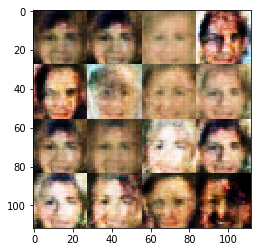

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 2.0239
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 4.2626
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 4.2694
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 2.5456
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 2.4501
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 5.8699
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.6878
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 4.9275


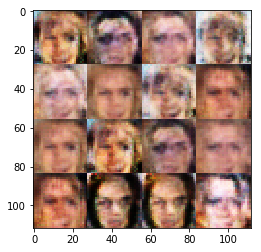

Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 2.5761
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.1579
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 4.3534
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 2.3647
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 4.1527
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.9199
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 3.1766
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.7748


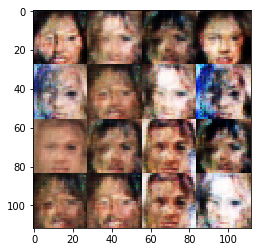

Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.6601
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 4.6635
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 4.0123
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 2.3712
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.6885
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 5.9159
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 2.7481
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.7269
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.6785


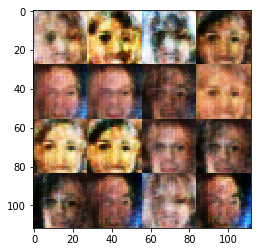

Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 5.2249
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 5.1363
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 2.5410
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 4.4305
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 3.9702
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 4.0115
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.3039
Epoch 1/1... Discriminator Loss: 2.8507... Generator Loss: 0.1761


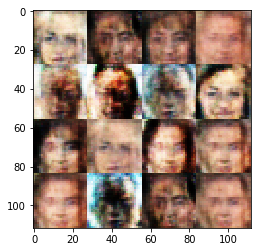

Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 2.7742
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 2.5005
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.8253
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 3.6566
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 2.0000
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.6426
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.4135


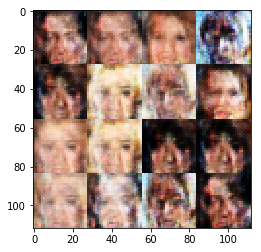

Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 2.0798
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.2342
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.4282
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.3844
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 4.6266
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.2196
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0154


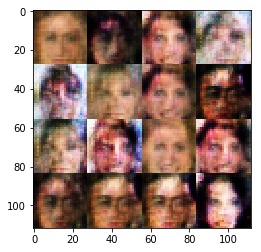

Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 3.1077
Epoch 1/1... Discriminator Loss: 1.9396... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.8095
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 1.8152
Epoch 1/1... Discriminator Loss: 2.8247... Generator Loss: 9.2588
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 2.7148
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 4.5932
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 2.3619
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.1925


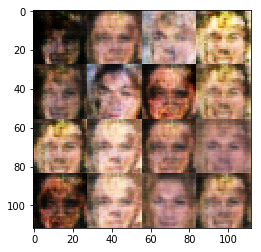

Epoch 1/1... Discriminator Loss: 2.4954... Generator Loss: 8.1601
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 3.2283
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 3.6538
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 5.9146
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 2.5404
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 4.4453
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 3.0895


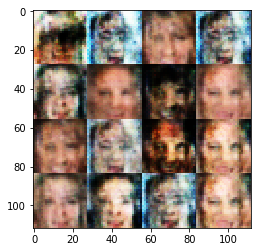

Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 2.5328
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 4.1856
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 4.7871
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 2.9309
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 6.2801
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.9320
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 4.3632
Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 4.0714


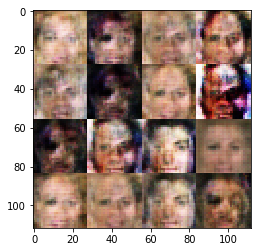

Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 2.5941
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 5.8541
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 4.7929
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 1.9078
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 4.0833
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.7110
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 5.0930
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.7691
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.7470


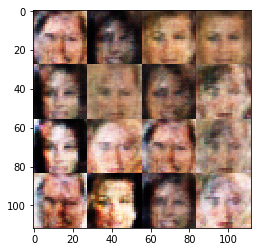

Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 3.0542
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 1.6135
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 3.3487
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 7.6595
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 2.4721
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 3.6784


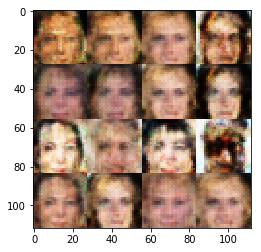

Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 3.0517
Epoch 1/1... Discriminator Loss: 1.8257... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 5.8218
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 2.1683
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 4.4995
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.5887
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 2.5250


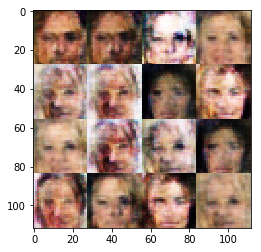

Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 2.5021
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 2.4225
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 2.2730
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 4.0302
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 4.5620
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.7628
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 2.0582
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 4.1372
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 2.1727


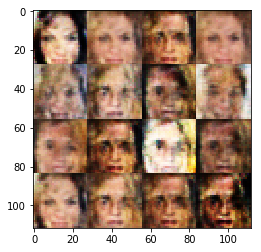

Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.4054
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 4.5975
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 2.8926
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 5.2417
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 2.7172


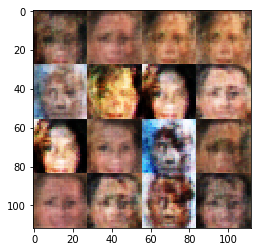

Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 2.5324
Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.5550
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.4554
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 2.5565
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 5.0713
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 3.5090
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.8730


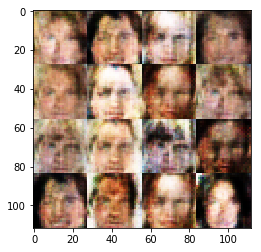

Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 3.2031
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 2.4412
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 5.4172
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 4.4706
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 3.2573
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7522
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 3.4073
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.8654


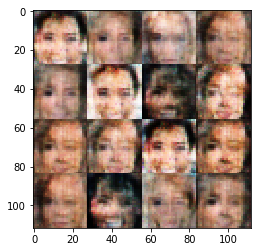

Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 4.1335
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 2.5260
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.3168
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.7835
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 4.1341
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 4.6854
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 3.1944
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 2.3459
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 6.1887


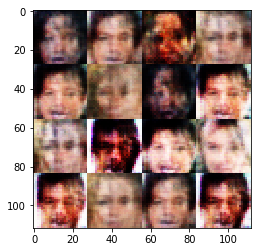

Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 3.6025
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 3.3463
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 4.2470
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 3.7006
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.9975
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.7253
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 2.0010
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9009


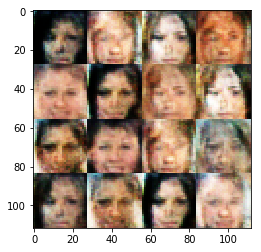

Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 3.7399
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 2.1199
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 2.7603
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 2.3290
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 4.0245
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.6530


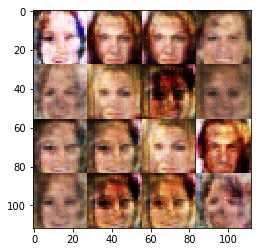

Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 3.1784
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 2.9910
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 5.4060
Epoch 1/1... Discriminator Loss: 2.1040... Generator Loss: 0.3271
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 3.1449
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.3130
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.4431
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 2.3886


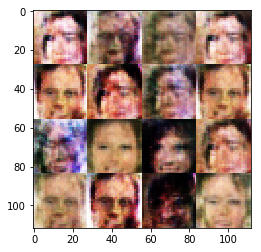

Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.3843
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 5.7718
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 1.8511
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.6016
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.9928


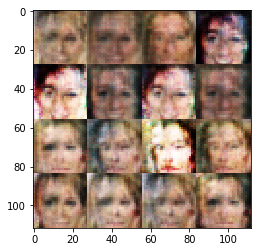

Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 2.0404
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 6.0474
Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 4.4524
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 4.3815
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 5.9177
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.3881
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 2.3795
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.2467


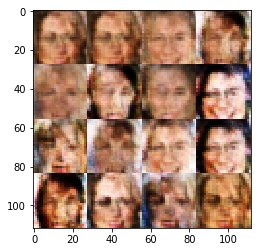

Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 4.0905
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 3.7723
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 2.6904
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.0493
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 2.4369
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.4295
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 4.8599
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.1332


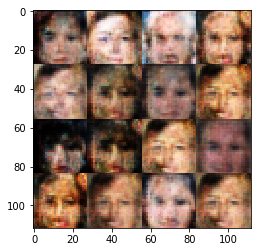

Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 2.1754
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.1765
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 8.6343
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 3.6377
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 2.1432
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.5522
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 3.5036


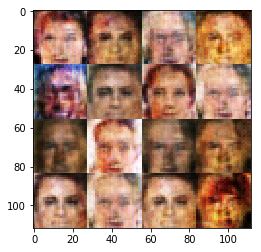

Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 1.8182... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 4.5948
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 2.0887
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.4840
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.9865


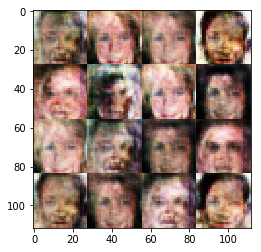

Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.7631
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 5.9549
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 3.1253
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 3.2745
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 3.6818
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 3.8239
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 2.1651
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 4.5307
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 3.6337


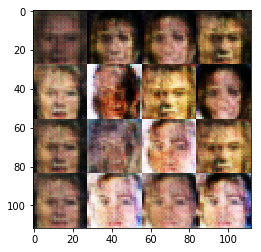

Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 2.9517
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 3.8098
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 6.1058
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.7058
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 2.1976
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 4.7577
Epoch 1/1... Discriminator Loss: 2.8446... Generator Loss: 7.4428
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 5.4605
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 6.1686


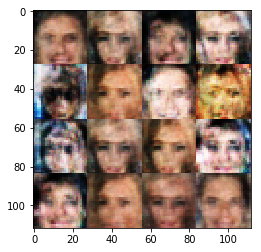

Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 3.8510
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 4.4890
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 3.2522
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 3.2235
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 2.7256
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 3.0086
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 3.0548
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 3.5593
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.0432


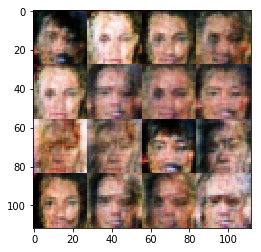

Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 3.2916
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 5.1963
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 2.0136
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 3.8290
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 2.2827
Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 2.8400


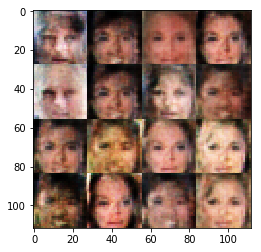

Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 3.5182
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.5126
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.9510
Epoch 1/1... Discriminator Loss: 2.3013... Generator Loss: 8.1486
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 2.4711
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.3112


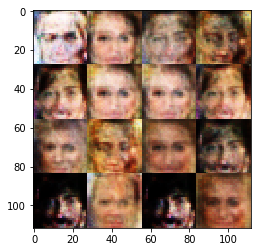

Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 2.0099
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 3.5201
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 5.4559
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 4.6036
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 2.4568
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.9244
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 3.1286


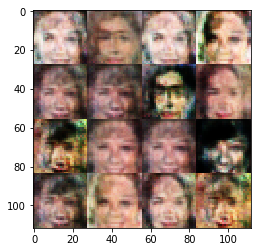

Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 3.6326
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 4.2602
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.5179
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.1643
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 3.2206
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 4.8063
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.3431


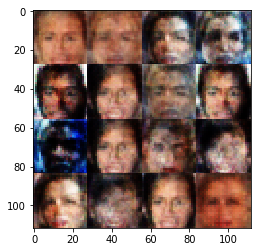

Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.5073
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 2.2774
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 4.8695


In [13]:
batch_size = 32
z_dim = 3
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。